In [48]:
!pip install pyspark==3.3.2


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\udnath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [49]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, avg, max as spark_max, to_date, year, month

In [50]:
spark = SparkSession.builder \
    .appName("Sales Data Analysis") \
    .getOrCreate()

In [51]:
df = spark.read.csv("sales_dataset.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

+------+--------------+----------+----------+--------------+----------+---------------+---------+-------------+---------------+----------+----------+------+---------------+---------------+-----------+--------------------+--------+
|Row ID|       OrderID| OrderDate|  ShipDate|      ShipMode|CustomerID|   CustomerName|  Segment|      Country|           City|     State|PostalCode|Region|      ProductID|       Category|SubCategory|         ProductName|   Sales|
+------+--------------+----------+----------+--------------+----------+---------------+---------+-------------+---------------+----------+----------+------+---------------+---------------+-----------+--------------------+--------+
|     1|CA-2017-152156|08-11-2017|11-11-2017|  Second Class|  CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentucky|     42420| South|FUR-BO-10001798|      Furniture|  Bookcases|Bush Somerset Col...|  261.96|
|     2|CA-2017-152156|08-11-2017|11-11-2017|  Second Class|  CG-12520|    C

In [52]:
df = df.withColumn("OrderDate", to_date(col("OrderDate"), "dd-MM-yyyy")) \
       .withColumn("ShipDate", to_date(col("ShipDate"), "dd-MM-yyyy"))

In [53]:
df.groupBy().agg(sum("Sales").alias("TotalSales")).show()

+------------------+
|        TotalSales|
+------------------+
|2237133.1626999523|
+------------------+



In [54]:
df.groupBy("Category").agg(sum("Sales").alias("TotalSales")).orderBy(col("TotalSales").desc()).show()

+---------------+-----------------+
|       Category|       TotalSales|
+---------------+-----------------+
|     Technology|827201.9069999964|
|      Furniture|719791.4556999996|
|Office Supplies|690139.8000000035|
+---------------+-----------------+



In [55]:
df.groupBy("Region").agg(sum("Sales").alias("TotalSales")).orderBy(col("TotalSales").desc()).show()
df.withColumn("Year", year("OrderDate")) \
  .withColumn("Month", month("OrderDate")) \
  .groupBy("Year","Month").agg(sum("Sales").alias("MonthlySales")) \
  .orderBy("Year","Month").show()

+-------+------------------+
| Region|        TotalSales|
+-------+------------------+
|   West| 698354.7745000002|
|   East| 663043.8579999986|
|Central|489321.39120000065|
|  South|386413.13900000043|
+-------+------------------+

+----+-----+------------------+
|Year|Month|      MonthlySales|
+----+-----+------------------+
|2015|    1|14130.160999999998|
|2015|    2|          4119.816|
|2015|    3| 55040.98700000002|
|2015|    4|27751.070999999993|
|2015|    5|         23630.683|
|2015|    6| 34298.34760000002|
|2015|    7|33336.022999999994|
|2015|    8|26811.580499999993|
|2015|    9| 81342.98279999998|
|2015|   10|31394.940999999988|
|2015|   11| 77622.53469999999|
|2015|   12|        68001.2745|
|2016|    1|17977.997599999995|
|2016|    2|11924.271999999999|
|2016|    3| 32234.35839999999|
|2016|    4|32599.742499999986|
|2016|    5|29209.414500000003|
|2016|    6|23461.766000000003|
|2016|    7|28377.822999999986|
|2016|    8|        36300.9382|
+----+-----+------------------+

In [56]:
df.groupBy("CustomerName").agg(sum("Sales").alias("TotalSales")) \
  .orderBy(col("TotalSales").desc()) \
  .show(10, truncate=False)

+------------------+------------------+
|CustomerName      |TotalSales        |
+------------------+------------------+
|Sean Miller       |25043.05          |
|Tamara Chand      |19017.847999999998|
|Raymond Buch      |15117.339         |
|Tom Ashbrook      |14595.62          |
|Adrian Barton     |14355.610999999997|
|Sanjit Chand      |14142.333999999999|
|Ken Lonsdale      |14071.917         |
|Hunter Lopez      |12873.297999999999|
|Sanjit Engle      |12209.438000000002|
|Christopher Conant|12129.072         |
+------------------+------------------+
only showing top 10 rows



In [57]:
df.withColumn("DeliveryDays", (col("ShipDate").cast("long") - col("OrderDate").cast("long"))) \
  .agg(avg("DeliveryDays").alias("AvgDeliveryDays")) \
  .show()

+---------------+
|AvgDeliveryDays|
+---------------+
|           null|
+---------------+



In [58]:
!pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\udnath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [59]:
!pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\udnath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


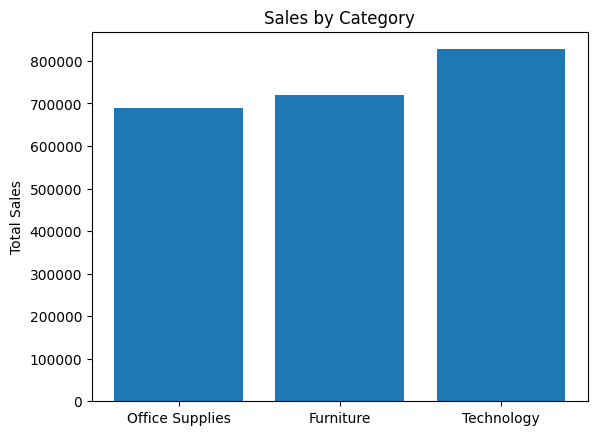

In [60]:
import matplotlib.pyplot as plt

# Sales by Category
sales_by_category = df.groupBy("Category").agg(sum("Sales").alias("TotalSales")).toPandas()

plt.bar(sales_by_category["Category"], sales_by_category["TotalSales"])
plt.title("Sales by Category")
plt.ylabel("Total Sales")
plt.show()

In [61]:
#------------------------------------------------------
#------------------------------------------------------
#------------------------------------------------------

In [62]:
spark = SparkSession.builder \
    .appName("RetailForecasting") \
    .master("local[*]") \
    .config("spark.ui.enabled", "false") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

In [63]:
from pyspark.sql.functions import col, to_date, year, month, date_format, sum as _sum, when, trim

# Adjust the path if needed
df = spark.read.csv("sales_dataset.csv", header=True, inferSchema=True)

# Basic cleaning
df = df.select([trim(col(c)).alias(c) for c in df.columns])

# Parse dates (your format is dd-MM-yyyy from the snippet)
df = df.withColumn("OrderDate", to_date(col("OrderDate"), "dd-MM-yyyy")) \
       .withColumn("ShipDate", to_date(col("ShipDate"), "dd-MM-yyyy"))

# Keep only valid rows
df = df.filter(col("OrderDate").isNotNull() & col("Sales").isNotNull())

# Normalize common typos in categorical fields (example)
df = df.withColumn("Category", when(col("Category")=="Furnture","Furniture").otherwise(col("Category")))

In [64]:
from pyspark.sql.functions import concat_ws, lit

# Year-Month string for readability + true month start date for plotting/stats
df_m = (df
        .withColumn("Year", year("OrderDate"))
        .withColumn("Month", month("OrderDate"))
        .withColumn("YearMonth", date_format(col("OrderDate"), "yyyy-MM"))
       )

# Monthly revenue by SubCategory (change grouping to ProductName or Category as needed)
monthly_rev_sc = (df_m.groupBy("Year", "Month", "YearMonth", "SubCategory")
                  .agg(_sum("Sales").alias("Revenue"))
                  .orderBy("Year", "Month", "SubCategory"))

monthly_rev_sc.show(10, truncate=False)

+----+-----+---------+-----------+------------------+
|Year|Month|YearMonth|SubCategory|Revenue           |
+----+-----+---------+-----------+------------------+
|2015|1    |2015-01  |Accessories|827.8900000000001 |
|2015|1    |2015-01  |Appliances |312.58000000000004|
|2015|1    |2015-01  |Art        |176.99            |
|2015|1    |2015-01  |Binders    |791.5299999999999 |
|2015|1    |2015-01  |Bookcases  |1010.0550000000001|
|2015|1    |2015-01  |Chairs     |4187.700000000001 |
|2015|1    |2015-01  |Envelopes  |194.36            |
|2015|1    |2015-01  |Fasteners  |31.12             |
|2015|1    |2015-01  |Furnishings|686.522           |
|2015|1    |2015-01  |Labels     |44.746            |
+----+-----+---------+-----------+------------------+
only showing top 10 rows



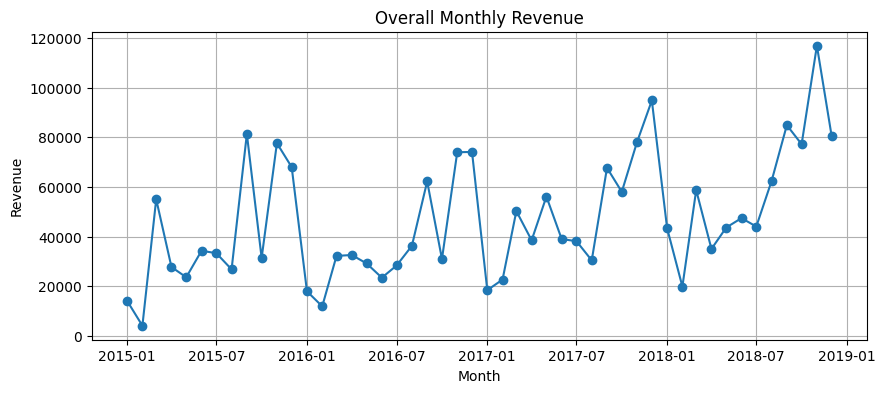

In [65]:
# 3a) Overall monthly revenue (across all subcategories) – for a quick trend
overall_m = (df_m.groupBy("Year", "Month", "YearMonth")
             .agg(_sum("Sales").alias("Revenue"))
             .orderBy("Year", "Month"))

overall_pd = overall_m.toPandas()

import pandas as pd
import matplotlib.pyplot as plt

overall_pd["Date"] = pd.to_datetime(overall_pd["YearMonth"] + "-01")
overall_pd = overall_pd.sort_values("Date")

plt.figure(figsize=(10,4))
plt.plot(overall_pd["Date"], overall_pd["Revenue"], marker="o")
plt.title("Overall Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

In [66]:
# 3b) Top 10 subcategories by total revenue (to pick for forecasting focus)
top_sc = (monthly_rev_sc.groupBy("SubCategory")
          .agg(_sum("Revenue").alias("TotalRevenue"))
          .orderBy(col("TotalRevenue").desc())
          .limit(10))

top_sc.show(truncate=False)

+-----------+------------------+
|SubCategory|TotalRevenue      |
+-----------+------------------+
|Phones     |327528.482        |
|Chairs     |322822.73099999997|
|Storage    |212302.99599999996|
|Tables     |202810.62799999997|
|Binders    |196538.16100000002|
|Machines   |189238.631        |
|Accessories|164186.7          |
|Copiers    |146248.094        |
|Bookcases  |113813.19870000002|
|Appliances |104618.40300000002|
+-----------+------------------+



In [67]:
# Choose a target series level:
TARGET_LEVEL = "SubCategory" # change to "ProductName" or "Category"
TARGET_VALUE = "Bookcases" # change one of the values you have

from pyspark.sql.functions import to_date

series_df = (monthly_rev_sc
             .filter(col(TARGET_LEVEL) == TARGET_VALUE)
             .select("YearMonth","Revenue")
             .orderBy("YearMonth"))

In [77]:
# Convert to pandas time series
s_pd = series_df.toPandas().copy()
if s_pd.empty:
    raise ValueError(f"No data found for {TARGET_LEVEL} == '{TARGET_VALUE}'. Pick another value from top_sc results.")

s_pd["Date"] = pd.to_datetime(s_pd["YearMonth"] + "-01")
s_pd = s_pd.sort_values("Date").set_index("Date")
ts = s_pd["Revenue"].asfreq("MS") # month start frequency; fills gaps with NaN
ts = ts.fillna(0.0) # simple gap fill; refine if needed
ts.head()

# Train-test split: last 6 months as test (adjust if you have short history)
h = 6 # forecast horizon
if len(ts) <= h + 6:
    # ensure enough points; for short history, reduce horizon
    h = max(1, min(3, len(ts)//4))

train, test = ts.iloc[:-h], ts.iloc[-h:]
print(len(train), len(test))

42 6


In [69]:
# Baseline 1: Seasonal Naive (use value from same month last year; if not available, use last observation)
def seasonal_naive_forecast(train_series, horizon, season_length=12):
    import numpy as np
    values = train_series.values
    fc = []
    for i in range(horizon):
        idx = len(values) - season_length + i
        if idx >= 0:
            fc.append(values[idx])
        else:
            fc.append(values[-1] if len(values) else 0.0)
    return pd.Series(fc, index=test.index)

sn_fc = seasonal_naive_forecast(train, h, season_length=12)

In [70]:
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\udnath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [71]:
# Holt-Winters (triple exponential smoothing)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Try additive trend/seasonality (retail often works well); switch to 'mul' if strong multiplicative seasonality
seasonal_periods = 12 if len(train) >= 24 else None # only model seasonality if enough data
if seasonal_periods:
    hw_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods)
else:
    hw_model = ExponentialSmoothing(train, trend="add", seasonal=None)

hw_fit = hw_model.fit(optimized=True)
hw_fc = hw_fit.forecast(h)

In [72]:
# Compare on test (sMAPE / MAPE)
import numpy as np

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom == 0] = 1.0
    return 100 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1.0, y_true)
    return 100 * np.mean(np.abs((y_true - y_pred) / denom))

metrics = {
    "SeasonalNaive_sMAPE": smape(test.values, sn_fc.values),
    "SeasonalNaive_MAPE" : mape(test.values, sn_fc.values),
    "HoltWinters_sMAPE" : smape(test.values, hw_fc.values),
    "HoltWinters_MAPE" : mape(test.values, hw_fc.values),
}
metrics

{'SeasonalNaive_sMAPE': np.float64(64.5843977689252),
 'SeasonalNaive_MAPE': np.float64(74.97375071952219),
 'HoltWinters_sMAPE': np.float64(88.40566029012433),
 'HoltWinters_MAPE': np.float64(285.24234137093214)}

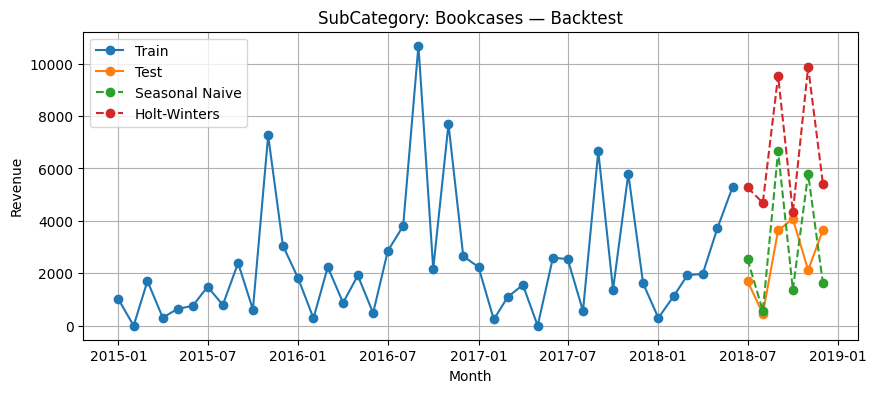

In [73]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, marker="o", label="Train")
plt.plot(test.index, test.values, marker="o", label="Test")
plt.plot(sn_fc.index, sn_fc.values, marker="o", linestyle="--", label="Seasonal Naive")
plt.plot(hw_fc.index, hw_fc.values, marker="o", linestyle="--", label="Holt-Winters")
plt.title(f"{TARGET_LEVEL}: {TARGET_VALUE} — Backtest")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()

In [74]:
# Refit Holt-Winters on full series
if seasonal_periods:
    final_model = ExponentialSmoothing(ts, trend="add", seasonal="add", seasonal_periods=seasonal_periods)
else:
    final_model = ExponentialSmoothing(ts, trend="add", seasonal=None)

final_fit = final_model.fit(optimized=True)
future_fc = final_fit.forecast(6) # next 6 months

future_fc

2019-01-01    1726.150666
2019-02-01     800.033393
2019-03-01    2129.432353
2019-04-01    1567.078615
2019-05-01    1959.081234
2019-06-01    2673.459760
Freq: MS, dtype: float64

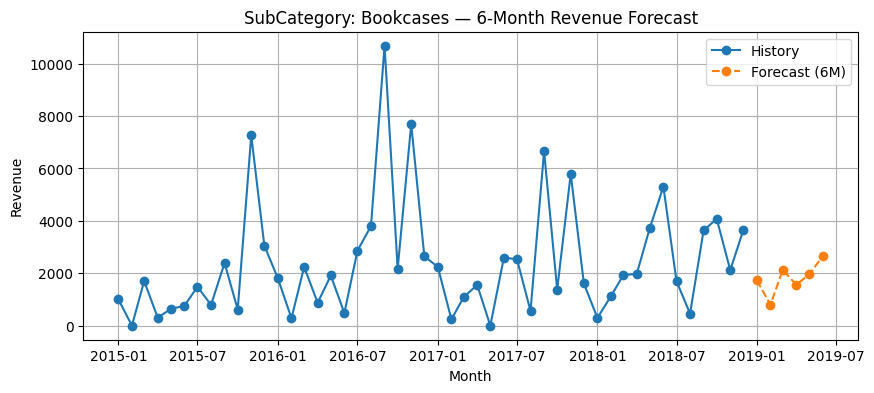

In [75]:
# Plot final forecast
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.values, marker="o", label="History")
plt.plot(future_fc.index, future_fc.values, marker="o", linestyle="--", label="Forecast (6M)")
plt.title(f"{TARGET_LEVEL}: {TARGET_VALUE} — 6-Month Revenue Forecast")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()

In [83]:
import itertools
from collections import defaultdict
import builtins

# Pick top N subcategories from earlier
top_sc_list = [r["SubCategory"] for r in top_sc.collect()]
N = builtins.min(10, len(top_sc_list))
chosen = top_sc_list[:N]

rows = []
for sc in chosen:
    s_df = (monthly_rev_sc.filter(col("SubCategory")==sc)
            .select("YearMonth","Revenue").orderBy("YearMonth")).toPandas()
    if s_df.empty: 
        continue
    s_df["Date"] = pd.to_datetime(s_df["YearMonth"] + "-01")
    s_df = s_df.sort_values("Date").set_index("Date")
    ts_sc = s_df["Revenue"].asfreq("MS").fillna(0.0)
    if len(ts_sc) < 6:
        continue

    sp = 12 if len(ts_sc) >= 24 else None
    mdl = ExponentialSmoothing(ts_sc, trend="add", seasonal=("add" if sp else None), seasonal_periods=sp).fit(optimized=True)
    fc = mdl.forecast(6)
    for dt, val in fc.items():
        rows.append({"SubCategory": sc, "Date": dt.strftime("%Y-%m-01"), "ForecastRevenue": float(val)})

batch_fc = pd.DataFrame(rows).sort_values(["SubCategory","Date"])
batch_fc.head()

,SubCategory,Date,ForecastRevenue
36,Accessories,2019-01-01,3508.175677
37,Accessories,2019-02-01,3523.735398
38,Accessories,2019-03-01,4335.659708
39,Accessories,2019-04-01,4113.752782
40,Accessories,2019-05-01,4536.548638


In [84]:
batch_fc.to_csv("subcat_6m_forecasts.csv", index=False)
print("Saved: subcat_6m_forecasts.csv")

Saved: subcat_6m_forecasts.csv


In [85]:
!pip install prophet

     ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/13.3 MB 1.7 MB/s eta 0:00:09
      --------------------------------------- 0.3/13.3 MB 3.8 MB/s eta 0:00:04
     - -------------------------------------- 0.7/13.3 MB 5.2 MB/s eta 0:00:03
     -- ------------------------------------- 1.0/13.3 MB 5.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/13.3 MB 5.6 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/13.3 MB 5.8 MB/s eta 0:00:03
     ----- ---------------------------------- 1.9/13.3 MB 6.0 MB/s eta 0:00:02
     ------ --------------------------------- 2.2/13.3 MB 6.1 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/13.3 MB 6.1 MB/s eta 0:00:02
     -------- ------------------------------- 2.8/13.3 MB 6.2 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/13.3 MB 6.2 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/13.3 MB 6


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\udnath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [87]:
!pip install plotly


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\udnath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/9.8 MB 2.0 MB/s eta 0:00:05
     - -------------------------------------- 0.4/9.8 MB 5.0 MB/s eta 0:00:02
     -- ------------------------------------- 0.7/9.8 MB 5.7 MB/s eta 0:00:02
     --- ------------------------------------ 0.8/9.8 MB 5.6 MB/s eta 0:00:02
     --- ------------------------------------ 0.8/9.8 MB 5.6 MB/s eta 0:00:02
     --- ------------------------------------ 0.8/9.8 MB 5.6 MB/s eta 0:00:02
     --- ------------------------------------ 0.9/9.8 MB 2.8 MB/s eta 0:00:04
     ---- ----------------------------------- 1.1/9.8 MB 3.2 MB/s eta 0:00:03
     ----- ---------------------------------- 1.3/9.8 MB 3.2 MB/s eta 0:00:03
     ------ --------------------------------- 1.6/9.8 MB 3.6 MB/s eta 0:00:03
     -------- ------------------------------- 2.0/9.8 MB 3.9 MB/s eta 0:00:02
     --------- ------------------------------ 2.2/9.8 MB 4.0 MB/s eta 

In [88]:
!pip install ipywidgets

     ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
     --------------------------------- ---- 122.9/139.8 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 139.8/139.8 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
     ----- ---------------------------------- 0.3/2.2 MB ? eta -:--:--
     -------------- ------------------------- 0.8/2.2 MB 9.8 MB/s eta 0:00:01
     -------------- ------------------------- 0.8/2.2 MB 8.6 MB/s eta 0:00:01
     ----------------------- ---------------- 1.3/2.2 MB 6.7 MB/s eta 0:00:01
     ---------------------------- ----------- 1.6/2.2 MB 6.7 MB/s eta 0:00:01
     -------------------------------- ------- 1.8/2.2 MB 7.7 MB/s eta 0:00:01
     ---------------------------------------  2.2/2.2 MB 7.3 MB/s eta 0:00:01
     ---------------------------------------- 2.2/2.2 MB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/216.6 kB ? eta -:--:--
     -


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\udnath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [89]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
print(df.columns)

['Row ID', 'OrderID', 'OrderDate', 'ShipDate', 'ShipMode', 'CustomerID', 'CustomerName', 'Segment', 'Country', 'City', 'State', 'PostalCode', 'Region', 'ProductID', 'Category', 'SubCategory', 'ProductName', 'Sales']


In [101]:
# Convert Spark DataFrame to Pandas
# pdf = df.toPandas()
import pyspark.sql.functions as F

summary_df = df.groupBy("SubCategory", "OrderDate") \
               .agg(F.sum("Sales").alias("TotalSales")) \
               .orderBy("OrderDate")

# Now convert only this smaller summary result to Pandas
summary_pdf = summary_df.toPandas()

# Ensure date is parsed correctly
summary_pdf['OrderDate'] = pd.to_datetime(summary_pdf['OrderDate'])

# Pick one subcategory (e.g., Chairs)
subcat = "Chairs"
sc_data = summary_pdf[summary_pdf['SubCategory'] == subcat]

# Aggregate daily sales
sc_daily = sc_data.groupby('OrderDate')['TotalSales'].sum().reset_index()

# Rename for Prophet
sc_daily = sc_daily.rename(columns={'OrderDate': 'ds', 'TotalSales': 'y'})
sc_daily.head()

,ds,y
0,2015-01-06,2573.820
1,2015-01-13,545.940
2,2015-01-20,1067.940
3,2015-02-11,60.890
4,2015-02-12,129.568


In [97]:
# Initialize and train
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(sc_daily)

00:07:49 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
# Create dataframe for next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

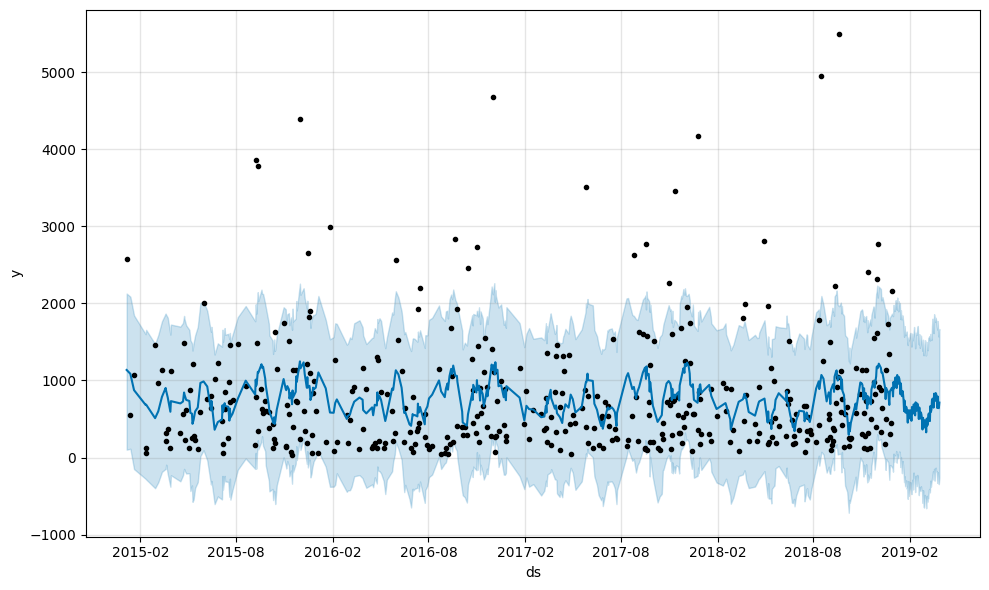

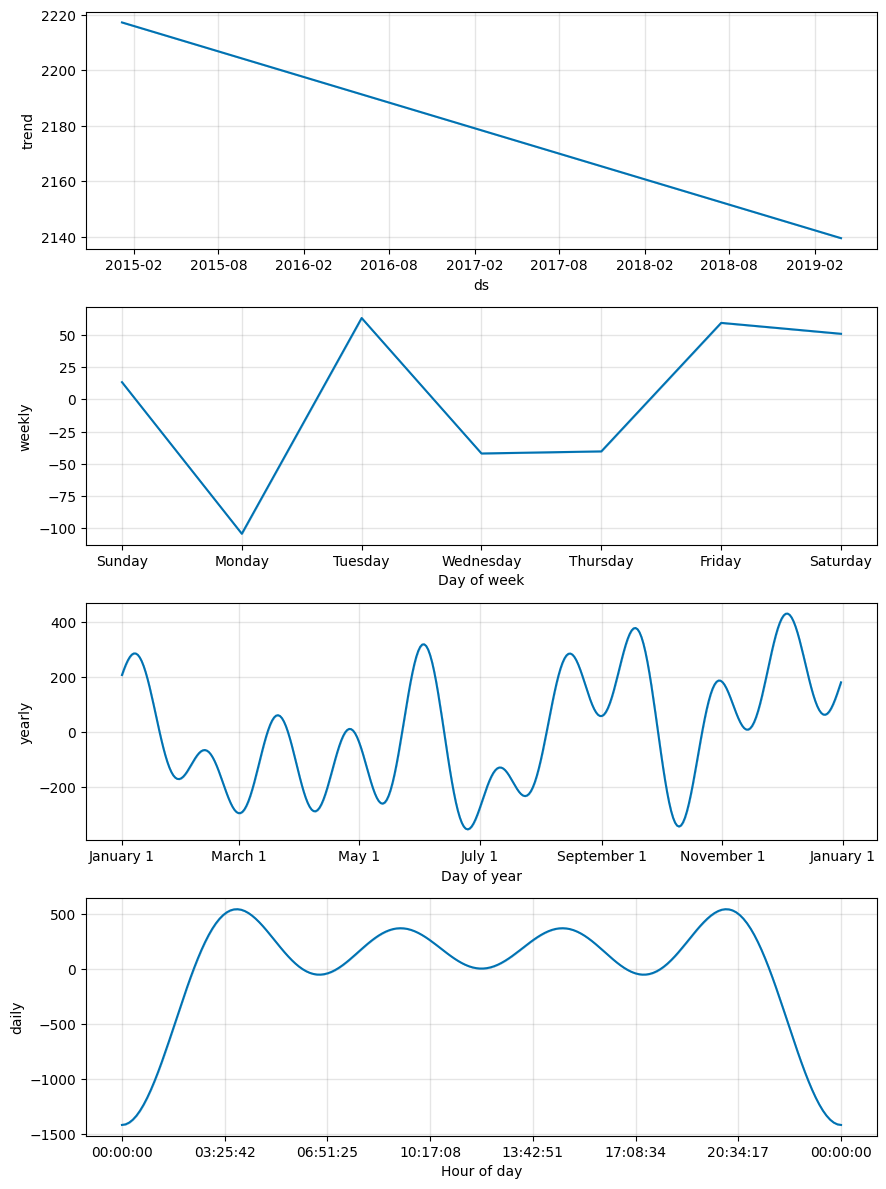

In [99]:
# Plot forecast
fig1 = model.plot(forecast)
plt.show()

# Plot components (trend, yearly seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.show()